# Ejercicio 4

In [1]:
import sys; sys.path.append("..")

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

from src.perceptron_multicapa import PerceptronMulticapa, Layer
from src.optimizer import SGD, Momentum, RMSprop, AdaGrad, Adam

# Dataset
usamos sklearn para solo obtener los datos.

In [2]:
from sklearn import datasets    # Solo lo usamos para obtener los datos
digits = datasets.load_digits()

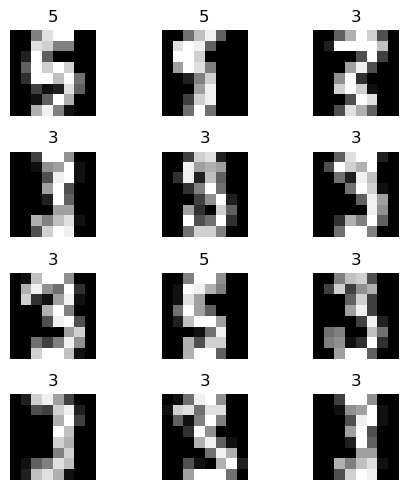

In [3]:
indices = [i for i, y in enumerate(digits.target) if y in [5, 3]] # TODO probar diferentes combinaciones
fig, ax = plt.subplots(4, 3, figsize=(5, 5))

for i in range(4):
    for j in range(3):
        ind = np.random.choice(indices)

        ax[i, j].imshow(digits.data[ind].reshape(8, 8), cmap="gray")
        ax[i, j].set_title(digits.target[ind])
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()

In [4]:
# Guardo dataset en data/
# np.savetxt("../data/mnist_x.txt", digits.data, fmt="%.0f")
# np.savetxt("../data/mnist_y.txt", digits.target, fmt="%.0f")

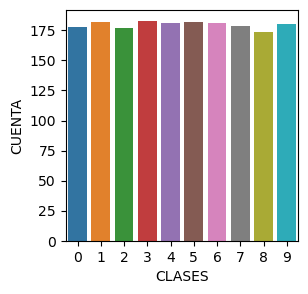

In [5]:
# Verificamos que se pueda leer el archivo realizado
target = np.loadtxt("../data/mnist_y.txt").astype(int)

df = pd.DataFrame(target, columns=["CLASES"])
count = df.groupby("CLASES")["CLASES"].count()

fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=count.index, y=count.values, hue=count.index.astype(str))
plt.ylabel("CUENTA")
plt.show()

# Primer modelo

In [6]:
optimizer = Adam()
l1 = Layer(64, 15, activation_function="sigmoid")
l2 = Layer(15, 15, activation_function="sigmoid")
l3 = Layer(15, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2, l3], optimizer)

# cargo dataset
def get_dataset():
    x = np.loadtxt("../data/mnist_x.txt").astype(int)
    y = np.loadtxt("../data/mnist_y.txt").astype(int)
    y_enc = p.one_hot_encoding(y)
    
    # conjunto entrenamiento - clasificacion
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    
    split = np.floor(len(x) * 0.7).astype(int)
    
    x_train = x[:split]
    y_train = y_enc[:split]
    
    x_test = x[split:]
    y_test = y[split:]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_dataset()

In [7]:
history = p.train(x_train, y_train, epochs=50, batch_size=10)

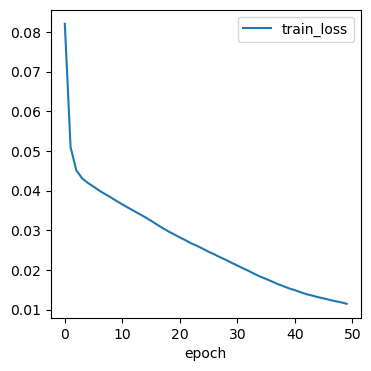

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
df = pd.DataFrame(history)
df.plot("epoch", "train_loss", ax=ax)
plt.show()

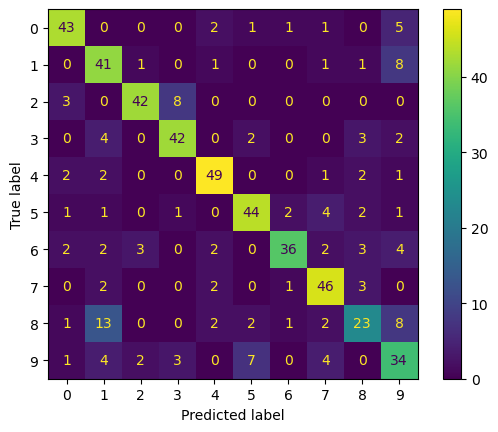

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_hat = p.predict(x_test)
cfm = confusion_matrix(y_test, y_hat)
cfd = ConfusionMatrixDisplay(cfm)
cfd.plot()
plt.show()

El resultado es bastante bueno 😀

# Variación de optimizadores

In [10]:
x_train, y_train, x_test, y_test = get_dataset()

l1 = Layer(64, 15, activation_function="sigmoid")
l2 = Layer(15, 15, activation_function="sigmoid")
l3 = Layer(15, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2, l3])

In [11]:
optimizadores = {
    "SGD": SGD(),
    "Momentum": Momentum(),
    "RMSprop": RMSprop(),
    "AdaGrad": AdaGrad(),
    "Adam": Adam()
}

In [12]:
from copy import deepcopy

results = {}
modelos = {}
for name, opt in optimizadores.items():
    p_copy = deepcopy(p)
    p_copy.optimizer = opt
    p_copy.optimizer.learning_rate = 0.001
    modelos[name] = p_copy
    results[name] = modelos[name].train(x_train, y_train, epochs=50, batch_size=10)
    

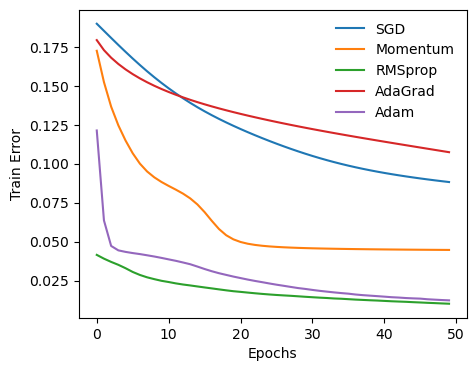

In [13]:
ax, fig = plt.subplots(figsize=(5,4))

for name, h in results.items():
    plt.plot(
        [d["epoch"] for d in h],
        [d["train_loss"] for d in h],
        label=name
    )
plt.ylabel("Train Error")
plt.xlabel("Epochs")
plt.legend(frameon=False)
plt.show()

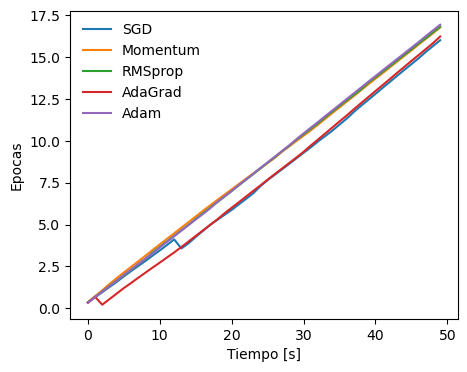

In [14]:
ax, fig = plt.subplots(figsize=(5,4))

for name, h in results.items():
    plt.plot(
        [d["epoch"] for d in h],
        [d["elapsed_training_time"] for d in h],
        label=name
    )
plt.ylabel("Epocas")
plt.xlabel("Tiempo [s]")
plt.legend(frameon=False)
plt.show()

## Resultados sobre el conjunto de test

In [15]:
metrics = []
for name, modelo in modelos.items():
    y_hat = modelo.predict(x_test)
    clases = np.unique(y_test)
    resultados = {cl: {"TP": 0, "FP": 0, "FN": 0, "TN": 0, "modelo": name, "clases": cl.astype(str)} for cl in clases}    
    for yt, yp in zip(y_test, y_hat):
        for cl in clases:
            if yp == cl and yt == cl:
                resultados[cl]['TP'] += 1
            elif yp == cl and yt != cl:
                resultados[cl]['FP'] += 1
            elif yp != cl and yt == cl:
                resultados[cl]['FN'] += 1
            elif yp != cl and yt != cl:
                resultados[cl]['TN'] += 1
    metrics.extend(resultados.values())

df = pd.DataFrame(metrics)
df["AC"] = (df.TP + df.TN) / (df.TP + df.TN + df.FP + df.FN)
df["PC"] = (df.TP) / (df.TP + df.FP)
df["RC"] = (df.TP) / (df.TP + df.FN)
df["F1"] = 2 * df.TP / (2 * df.TP + df.FP + df.FN)

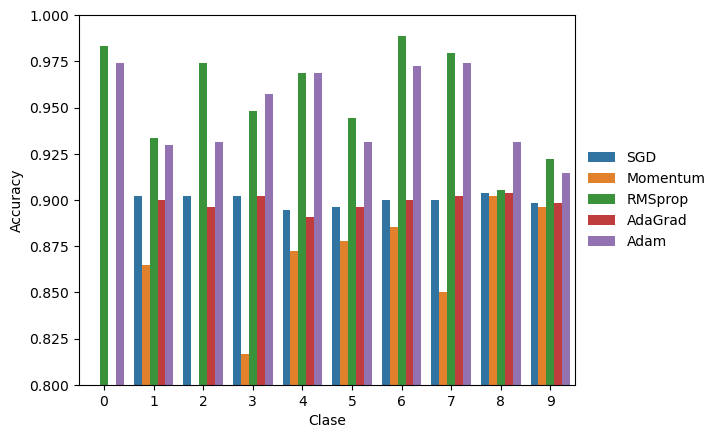

In [16]:
sns.barplot(data=df, x="clases", y="AC", hue="modelo")
plt.legend(bbox_to_anchor=[1.0, 0.5], loc='center left', frameon=False)
plt.ylabel("Accuracy")
plt.xlabel("Clase")
plt.ylim(0.8, 1.0)
plt.show()

In [17]:
df.groupby("modelo")["AC"].mean()

modelo
AdaGrad     0.821481
Adam        0.948519
Momentum    0.846667
RMSprop     0.954815
SGD         0.819630
Name: AC, dtype: float64

# Batch y Learning Rate

In [18]:
x_train, y_train, x_test, y_test = get_dataset()

l1 = Layer(64, 15, activation_function="sigmoid")
l2 = Layer(15, 15, activation_function="sigmoid")
l3 = Layer(15, 10, activation_function="sigmoid")
p = PerceptronMulticapa([l1, l2, l3], optimizer=Adam())

In [19]:
parametros = []
for lr in [0.001, 0.01, 0.1]:
    for bs in [1, 10, 100]:
        parametros.append({"lr": lr, "bs": bs})

In [20]:
from copy import deepcopy

results = {}
modelos = {}
for param in parametros:
    p_copy = deepcopy(p)
    p_copy.optimizer.learning_rate = param["lr"]
    identif = "lr {} - bs {}".format(param["lr"], param["bs"])
    modelos[identif] = p_copy
    results[identif] = modelos[identif].train(x_train, y_train, epochs=50, batch_size=param["bs"], k_fold=5)
    

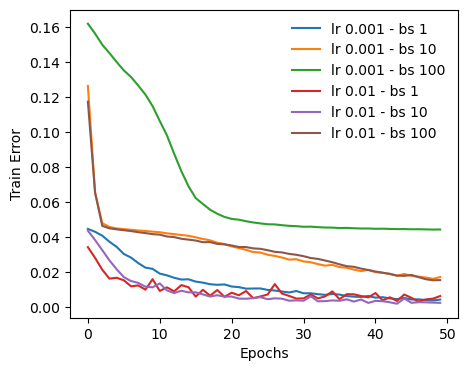

In [21]:
ax, fig = plt.subplots(figsize=(5,4))

for name, h in results.items():
    if "lr 0.1" in name: continue
    plt.plot(
        [d["epoch"] for d in h],
        [d["train_loss"] for d in h],
        label=name
    )
plt.ylabel("Train Error")
plt.xlabel("Epochs")
plt.legend(frameon=False)
plt.show()

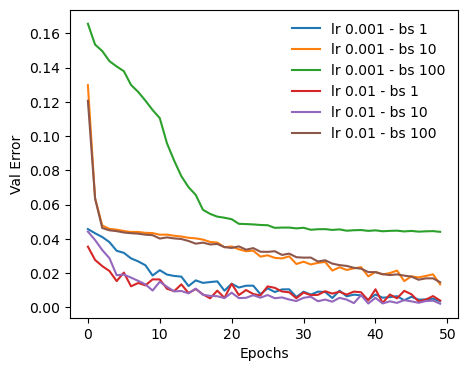

In [22]:
ax, fig = plt.subplots(figsize=(5,4))

for name, h in results.items():
    if "lr 0.1" in name: continue
    plt.plot(
        [d["epoch"] for d in h],
        [d["val_loss"] for d in h],
        label=name
    )
plt.ylabel("Val Error")
plt.xlabel("Epochs")
plt.legend(frameon=False)
plt.show()

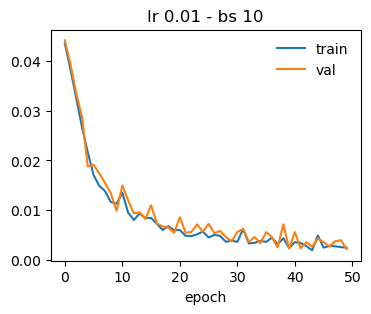

In [23]:
label = 'lr 0.01 - bs 10'
data = results[label]

ax, fig = plt.subplots(figsize=(4,3))
plt.plot(
    [d["epoch"] for d in data],
    [d["train_loss"] for d in data],
    label="train"
)
plt.plot(
    [d["epoch"] for d in data],
    [d["val_loss"] for d in data],
    label="val"
)
plt.xlabel("loss")
plt.xlabel("epoch")
plt.title(label)
plt.legend(frameon=False)
plt.show()

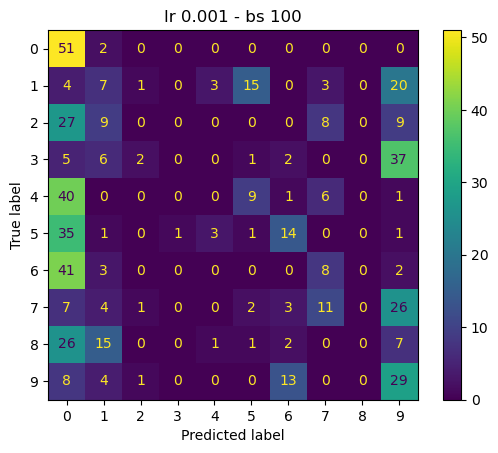

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label = 'lr 0.001 - bs 100'
p = modelos[label]

y_hat = p.predict(x_test)
cfm = confusion_matrix(y_test, y_hat)
cfd = ConfusionMatrixDisplay(cfm)
cfd.plot()
plt.title(label)
plt.show()